In [122]:
import numpy as np
import pandas as pd
import tqdm
import jax
import jax.numpy as jnp
import string
import tensorflow as tf
import time
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

# import libraries relevant to plotting (t-SNE)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Data Preprocessing

In [44]:
data = pd.read_csv('./data/raw data/raw_data.csv', header=0, names=['text'], usecols=[1])
print(f'Data Shape: {data.shape}')
data.head()

Data Shape: (13368, 1)


,text
0,"Sally Forrest, an actress-dancer who graced th..."
1,A middle-school teacher in China has inked hun...
2,A man convicted of killing the father and sist...
3,Avid rugby fan Prince Harry could barely watch...
4,A Triple M Radio producer has been inundated w...


In [45]:
# remove punctuation
punctuations = string.punctuation
def remove_punctuation(txt):
    for char in punctuations:
        if char in txt:
            txt = txt.replace(char, "")
    return txt

# change to lower caps
data['text'] = data['text'].str.lower()

# remove punctuations
data['text'] = data['text'].apply(remove_punctuation)

In [46]:
# remove stopwords
# read stopwords from data/raw data/stopwords.txt
stop_words = []
with open('./data/raw data/stopwords.txt', 'r') as f:
    for line in f:
        stop_words.append(line.strip())

def remove_stopwords(txt):
    txt = [word for word in txt.split() if word not in stop_words]
    return ' '.join(txt)

data['text'] = data['text'].apply(remove_stopwords)

In [47]:
# split each row into list of words
data_lst = data['text'].apply(lambda txt: txt.split(" "))

# select number of rows to be used as training data
nrows = 200
random_indices = np.random.randint(low=0, high=len(data_lst), size=nrows)
data_lst = data_lst[random_indices].reset_index(drop=True)

print(f'Number of rows of data: {len(data_lst)}')
data_lst[:5]

Number of rows of data: 200


0    [shocking, images, emerged, risks, injuries, s...
1    [wayne, rooney, switched, attention, boxing, g...
2    [star, wars, fans, flocked, tunisian, town, lu...
3    [video, emerged, claims, oscar, pistorius, pla...
4    [florida, teacher, claims, fired, reported, pr...
Name: text, dtype: object

In [48]:
# vocab dict
vocab, index = {}, 1
vocab['<pad>'] = 0
for line in data_lst:
    for word in line:
        if word not in vocab:
            vocab[word] = index
            index += 1

# inverse_vocab dict
inverse_vocab = {}
for word, index in vocab.items():
    inverse_vocab[index] = word

print(f'Vocab size: {len(vocab)}')

Vocab size: 15156


In [49]:
# sequences
sequences = []
for line in data_lst:
    vectorized_line = [vocab[word] for word in line]
    sequences.append(vectorized_line)

## Split Train and Test Sets

In [50]:
# split into train and test sets
# choose 20 random sequences
ntest = 20
test_indices = np.random.randint(low=0, high=len(sequences), size=ntest)
test_sequences = [sequences[i] for i in test_indices]
train_sequences = [sequences[i] for i in range(len(sequences)) if i not in test_indices]

In [51]:
# function to generate samples
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0,
          shuffle=True)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.reshape(tf.constant([context_word], dtype="int64"), (1,1))
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [52]:
# function to generate testing data
def generate_testing_data(sequences, vocab_size, window_size):
    targets, contexts, labels = [], [], []
    for sequence in tqdm(sequences):
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            window_size=window_size,
            negative_samples=0)
    for target_word, context_word in positive_skip_grams:
        targets.append(target_word)
        contexts.append(context_word)
        labels.append(1)
    return targets, contexts, labels

In [53]:
# generate training data
window_size = 5
num_ns = 4
vocab_size = len(vocab)
seed = 4212

targets, contexts, labels = generate_training_data(sequences=train_sequences,
                                                 window_size=window_size,
                                                 num_ns=num_ns,
                                                 vocab_size=vocab_size,
                                                 seed=seed)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print(f'targets shape: {targets.shape}')
print(f'contexts shape: {contexts.shape}')
print(f'labels shape: {labels.shape}')

100%|██████████| 181/181 [02:36<00:00,  1.16it/s]


targets shape: (325378,)
contexts shape: (325378, 5)
labels shape: (325378, 5)


In [54]:
# generate testing data
targets_test, contexts_test, labels_test = generate_testing_data(sequences=test_sequences,
                                                                    vocab_size=vocab_size,
                                                                    window_size=window_size)

targets_test = np.array(targets_test)
contexts_test = np.array(contexts_test)
labels_test = np.array(labels_test)

print(f'targets_test shape: {targets_test.shape}')
print(f'contexts_test shape: {contexts_test.shape}')
print(f'labels_test shape: {labels_test.shape}')

100%|██████████| 20/20 [00:00<00:00, 138.07it/s]

targets_test shape: (4360,)
contexts_test shape: (4360,)
labels_test shape: (4360,)


**Sanity Check on quality of training and testing data**

In [55]:
# training data
print(f"target_index    : {targets[0]}")
print(f"target_word     : {inverse_vocab[targets[0]]}")
print(f"context_indices : {contexts[0]}")
print(f"context_words   : {[inverse_vocab[c] for c in contexts[0]]}")
print(f"label           : {labels[0]}")

print("target  :", targets[0])
print("context :", contexts[0])
print("label   :", labels[0])

target_index    : 263
target_word     : trevino
context_indices : [ 297   39 1609 1620 1084]
context_words   : ['impossible', 'manage', 'represented', 'afresh', 'light']
label           : [1 0 0 0 0]
target  : 263
context : [ 297   39 1609 1620 1084]
label   : [1 0 0 0 0]


In [56]:
# testing data
print(f"target_index    : {targets_test[0]}")
print(f"target_word     : {inverse_vocab[targets_test[0]]}")
print(f"context_index : {contexts_test[0]}")
print(f"context_word   : {inverse_vocab[contexts_test[0]]}")
print(f"label           : {labels_test[0]}")

print("target  :", targets_test[0])
print("context :", contexts_test[0])
print("label   :", labels_test[0])

target_index    : 10003
target_word     : endanger
context_index : 62
context_word   : medical
label           : 1
target  : 10003
context : 62
label   : 1


## Minimizing Objective Function for SGNS

$$

\min_{\theta} = \frac{1}{N} \sum_{i=1}^{N} [log \sigma(u_{ic}^T)  + \sum_{k=1}^{K}log \sigma(-u_{kc}^T v_{iw})]

\\
\\
\theta = [U, V]

$$

In [57]:
# sigmoid function
def sigmoid(x):
    """Inputs a real number, outputs a real number"""
    return 1 / (1 + jnp.exp(-x))


In [58]:
# define function to get embedding vectors
def get_embedding_vectors(target, context, V, U):
    """
    Input (example)
    target = (188,)
    context = (93, 40, 1648, 1659, 1109)
    V: matrix of dim (n x |v|)
    U: matrix of dim (|v| x n)
        n = embedding dimension, |v| = vocab size

    Output
    v_t: target word vector, dimension: (n,)
    u_c: context word vectors, consists of u_pos and u_neg: dimension: (n, len(context))
    """
    target = target.astype(int)
    context = context.astype(int)
    v_t = V.T[target]
    u_c = U[context]
    return v_t, u_c

# t = targets[0]
# c = contexts[0]
# v_test, u_test = get_embedding_vectors(t, c, V, U)
# print(f'v_test shape: {v_test.shape}')
# print(f'u_test shape: {u_test.shape}')

In [59]:
# define local_loss function
@jax.jit
def local_loss(params):
    """
    Input (example)
    params = [v_t, jnp.array([u_pos, u_neg])]
        v_t: target word vector, dimension: (n,)
        u_c: context word vectors, consists of u_pos and u_neg: dimension: (len(context), n)

    Output
    local_loss: real number
    """
    v_t = params[0]
    u_c = params[1]
    return -jnp.log(sigmoid(jnp.dot(u_c[0], v_t))) - jnp.sum(jnp.log(sigmoid(-jnp.dot(u_c[1:], v_t))))

# p = [V[:, 0], U[:5, :]]
# print(f'local_loss: {local_loss(p)}')


In [60]:
# define gradient function
L_grad = jax.grad(local_loss)

# g = L_grad([V[:, 0], U[:5, :]])
# print(f"g[0] shape: {g[0].shape}")
# print(f"g[1] shape: {g[1].shape}")

In [61]:
# set up
n = 300
v = len(vocab)
V_init = np.random.normal(0, 1, size=(n, v)) / np.sqrt(v)
U_init = np.random.normal(0, 1, size=(v, n)) / np.sqrt(v)

targets_data = targets.astype(float)
contexts_data = contexts.astype(float)
labels_data = labels.astype(float)

print(f'V shape: {V_init.shape}')
print(f'U shape: {U_init.shape}')
print(f'targets_data shape: {targets_data.shape}')
print(f'contexts_data shape: {contexts_data.shape}')
print(f'labels_data shape: {labels_data.shape}')

V shape: (300, 15156)
U shape: (15156, 300)
targets_data shape: (325378,)
contexts_data shape: (325378, 5)
labels_data shape: (325378, 5)


In [73]:
# train using (stochastic) gradient descent

# set up
V = V_init.copy()
U = U_init.copy()
params = [V, U]

N = len(targets_data)
n_epochs = 100

lr = 0.1

epoch_losses = []

# gradient descent
for epoch in range(n_epochs):

    start_time = time.time()

    # shuffle data
    perm = np.random.permutation(N)
    targets_epoch = targets_data[perm]
    contexts_epoch = contexts_data[perm]
    labels_epoch = labels_data[perm]

    # every 20 epoch, lr -= 1
    if epoch == 50 and epoch == 75:
        lr /= 2

    losses = []
    for i in range(10000):
        # stop after 10000 iterations
        target = targets_epoch[i].astype(int) # ; print(f'target shape: {target.shape}')
        context = contexts_epoch[i].astype(int)# ; print(f'context shape: {context}')
        label = labels_epoch[i].astype(int)

        # get the embedding vectors
        v_t, u_c = get_embedding_vectors(target, context, V, U)

        # get the loss value and gradient
        loss_value = local_loss([v_t, u_c])
        grad = L_grad([v_t, u_c])

        # update the parameters
        partial_V = grad[0]
        partial_U = grad[1]
        
        V[:, target] = V[:, target] - lr * partial_V
        U[context, :] = U[context, :] - lr * partial_U

        # store the loss value
        losses.append(loss_value)
    
    # store epoch losses
    epoch_losses.append(np.mean(losses))

    end_time = time.time()
    
    # print epoch loss
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} \t loss = {np.mean(epoch_losses)} \t time = {end_time - start_time:.2f}s")

Epoch 1/100 	 loss = 3.464250087738037 	 time = 35.22s
Epoch 2/100 	 loss = 3.413017988204956 	 time = 34.76s
Epoch 3/100 	 loss = 3.255211591720581 	 time = 36.09s
Epoch 4/100 	 loss = 3.080596685409546 	 time = 34.69s
Epoch 5/100 	 loss = 2.9262003898620605 	 time = 36.11s
Epoch 6/100 	 loss = 2.7958145141601562 	 time = 33.64s
Epoch 7/100 	 loss = 2.68611741065979 	 time = 33.93s
Epoch 8/100 	 loss = 2.5930628776550293 	 time = 33.94s
Epoch 9/100 	 loss = 2.5146961212158203 	 time = 34.67s
Epoch 10/100 	 loss = 2.4448094367980957 	 time = 33.23s
Epoch 11/100 	 loss = 2.3824145793914795 	 time = 34.15s
Epoch 12/100 	 loss = 2.3300957679748535 	 time = 33.93s
Epoch 13/100 	 loss = 2.2828497886657715 	 time = 33.43s
Epoch 14/100 	 loss = 2.241057872772217 	 time = 33.50s
Epoch 15/100 	 loss = 2.2044739723205566 	 time = 33.70s
Epoch 16/100 	 loss = 2.170534133911133 	 time = 33.50s
Epoch 17/100 	 loss = 2.139336585998535 	 time = 34.82s
Epoch 18/100 	 loss = 2.111586332321167 	 time = 

Text(0, 0.5, 'Loss')

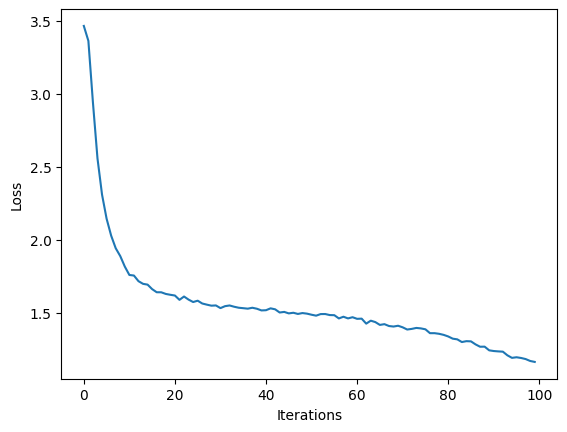

In [74]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [79]:
params[1].shape

(15156, 300)

In [80]:
# copy U and V
V_trained = np.copy(params[0])
U_trained = np.copy(params[1])

# check dimensions of U and V, 100 epochs, lr = 1, batch_size = 500
print(f'V_trained shape: {V_trained.shape}')
print(f'U_trained shape: {U_trained.shape}')

V_trained shape: (300, 15156)
U_trained shape: (15156, 300)


In [131]:
# save V_trained, U_trained as csv files
np.savetxt('./data/processed_data/V_trained.csv', V_trained, delimiter=',')
np.savetxt('./data/processed_data/U_trained.csv', U_trained, delimiter=',')

# reload these word embeddings
V_trained = np.loadtxt('./data/processed_data/V_trained.csv', delimiter=',')
U_trained = np.loadtxt('./data/processed_data/U_trained.csv', delimiter=',')

# check shape
print(f'V_trained shape: {V_trained.shape}')
print(f'U_trained shape: {U_trained.shape}')

V_trained shape: (300, 15156)
U_trained shape: (15156, 300)


**Sanity Check for Quality of Embeddings**

* Cosine Similarity Check
    * Select a few words from the dictionary
    * Find the most similar word (use cosine rule)

* t-SNE plot
    * e.g. king and queen vs cars and trucks
    * expect king and queen to be closer together and cars and trucks to be closer together

In [83]:
# define cosine similiarity function
def cosine_similarity(u, v):
    """
    Input
    u: vector of shape (n,) --> a word embeddng vector
    v: vector of shape (n,) --> potential similar word embedding vector

    Output
    cosine similarity: real number
    """
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

# given an index of a word in the vocab, find the most similar word using cosine similarity
def most_similar_word(word_index, V):
    """
    Input
    word_index: integer --> index of a word in the vocab
    V: matrix of shape (n, |v|) --> word embedding matrix

    Output
    most_similar_word: string
    """
    word_vector = V[:, word_index]
    similarities = []
    for i in range(V.shape[1]):
        if i == word_index:
            continue
        similarities.append(cosine_similarity(word_vector, V[:, i]))
    most_similar_index = np.argmax(similarities)
    return inverse_vocab[most_similar_index]

In [118]:
# select n random words from the vocab list
n = 5
random_words = np.random.choice(list(vocab.keys()), n)
print(f'Random words: {random_words}')

# get the embedding vectors of the random words
random_words_idx = [vocab[word] for word in random_words]

# find the most similar word to the random words
for i, word in enumerate(random_words):
    print(f"Most similar word to '{word}': {most_similar_word(random_words_idx[i], V_trained)}")

Random words: ['closed' 'ensuring' 'lavish' 'disabled' 'superbugs']
Most similar word to 'closed': net
Most similar word to 'ensuring': licorice
Most similar word to 'lavish': mezhprombank
Most similar word to 'disabled': hutchinson
Most similar word to 'superbugs': stacked


In [120]:
words = ['produced', 'lie', 'chromecast', 'evolved', 'closed']
# find most similar words
for word in words:
    word_idx = vocab[word]
    print(f"Most similar word to '{word}': {most_similar_word(word_idx, V_trained)}")


Most similar word to 'produced': farmed
Most similar word to 'lie': allegation
Most similar word to 'chromecast': google
Most similar word to 'evolved': undergo
Most similar word to 'closed': net


In [127]:
# plot t-SNE
tsne = TSNE(n_components=2, random_state=0)
V_trained_tsne = tsne.fit_transform(V_trained.T)

# plot only selected words in the list
target_words = ['produced', 'lie', 'chromecast', 'evolved', 'closed']
similar_words = [most_similar_word(vocab[word], V_trained) for word in words]

target_indices = [vocab[word] for word in words]
similar_indices = [vocab[word] for word in similar_words]
V_trained_tsne_target_words = V_trained_tsne[target_indices]
V_trained_tsne_similar_words = V_trained_tsne[similar_indices]


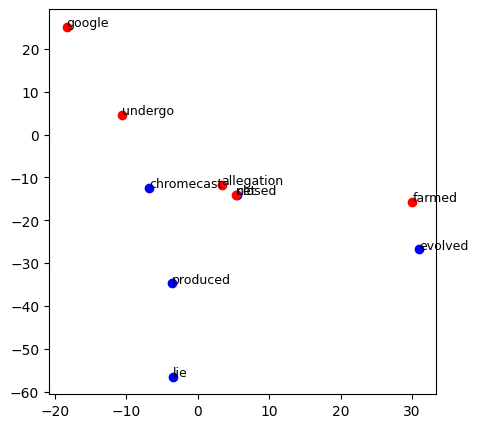

In [128]:
# plot the t-sne graph, labelling the data point with the words
plt.figure(figsize=(5, 5))
plt.scatter(V_trained_tsne_target_words[:, 0], V_trained_tsne_target_words[:, 1], color='blue')
plt.scatter(V_trained_tsne_similar_words[:, 0], V_trained_tsne_similar_words[:, 1], color='red')

# label the data points with its corresponding words slightly above each data point
for i, word in enumerate(words):
    x, y = V_trained_tsne_target_words[i]
    plt.text(x, y+0.1, word, fontsize=9)

    x, y = V_trained_tsne_similar_words[i]
    plt.text(x, y+0.1, similar_words[i], fontsize=9)

## Evaluate against test set

**Predict label of a (target, context) pair.**

In [88]:
# define a logistic function
# predicts if a (target word, context word) pair is a positive or negative sample
# takes as input a batch of target indices, batch of context indices, word embedding matrices V and U
def predict(target, context, V):
    """
    Input
    target: vector of shape (batch_size,) --> target word indices
    context: vector of shape (batch_size,) --> context word indices
    V: matrix of shape (n, |v|) --> word embedding matrix

    Output
    predicted: vector of shape (batch_size,) --> predicted values
    """
    target = target.astype(int)
    context = context.astype(int)
    v_t = V.T[target]
    u_c = V.T[context]
    return sigmoid(np.sum(v_t * u_c, axis=1))

# define a function that calculates the MSE between predicted and actual values
def mse(predicted, actual):
    """
    Input
    predicted: vector of shape (batch_size,) --> predicted values
    actual: vector of shape (batch_size,) --> actual values

    Output
    mse: real number --> mean squared error
    """
    return np.mean((predicted - actual) ** 2)

In [89]:
# evaluate on both train and test set
# since contexts_data and labels_data is of shape (N, num_ns+1), we should use the first column as the context
context_data = contexts_data[:, 0]
label_data = labels_data[:, 0]

# predict train set
train_predicted = predict(targets_data, context_data, V_trained)
mse_train = mse(train_predicted, label_data)

# predict test set
test_predicted = predict(targets_test, contexts_test, V_trained)
mse_test = mse(test_predicted, labels_test)

# print results
print(f'MSE Train: {mse_train}')
print(f'MSE Test: {mse_test}')

MSE Train: 0.034249816089868546
MSE Test: 0.1532941311597824


In [ ]:
# define function that takes in an index and vocab size and returns the one-hot encoding
def getOneHot(index, vocab_size):
    onehot = np.zeros(vocab_size)
    onehot[index] = 1
    return onehot

# define softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# test getOneHot and softmax function
print(getOneHot(1, 10))
print(softmax(np.array([1, 2, 3])))


In [ ]:
# check dimensions of U and V
print(f'U shape: {U.shape}')
print(f'V shape: {V.shape}')

In [ ]:
# see first 20 words in the vocab
test_words = list(vocab.keys())[20:40]
test_words

In [ ]:
# define cosine similarity scores between 2 word vectors
def similarity_score(target_word_embedding, context_word_embedding):
    return np.dot(target_word_embedding, context_word_embedding) / (np.linalg.norm(target_word_embedding) * np.linalg.norm(context_word_embedding))

# define a function that find the most similar words to a given word
def most_similar_words(word, V, n=5):
    scores = []
    target_word_idx = vocab[word]
    for i in range(V.shape[1]):
        if i == target_word_idx or inverse_vocab[i] == '<pad>':
            continue
        scores.append((inverse_vocab[i], similarity_score(V[:, target_word_idx], V[:, i])))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return scores[:n]

In [ ]:
# check similarity between words
# word: photos
print(most_similar_words('amazed', V_trained))

In [ ]:
# compute a forward pass through the skip-gram model

# define the forward pass function
def net(V, U, target_word_idx):
    target_hot = getOneHot(target_word_idx, len(vocab))
    return softmax( U @ V @ target_hot )

def predict(word, V, U):
    target_word_idx = vocab[word]
    y_hat = net(V, U, target_word_idx)
    # y_hat is the probability distribution over the vocab
    # select the top 5 words with the highest probability
    top_5 = np.argsort(y_hat)[-10:][::-1]
    top_5_words = [inverse_vocab[i] for i in top_5]
    return top_5_words

In [ ]:
# randomly select 1 word from vocab
word = np.random.choice(list(vocab.keys()))
y_hat = net(V_trained, U_trained, vocab[word])
print(f'Word: {word}')
predict(word, V_trained, U_trained)